# Task 1. Big Picture Thinking

---



Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

*   How big is the dataset? (in terms of MB)
*   How many entries does it have?
*   How many features does it have?
*   Does it contain any categorical data?
*   Is there any missing value?
*   What are some basic statistics you can learn right away about this dataset?



In [123]:
# Start by importing all of the major libraries we will be using
import sklearn                  # Model-Generation / ML
import numpy as np              # Advanced Computations 
import pandas as pd             # Construct and manipulate data frames 
import os                       # Input / Output
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

# Plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Mount Google Drive to access csv 
from google.colab import drive
drive.mount('/gdrive')\

# Make notebook's output stable across runs
np.random.seed(42)

# Get the data from google drive
data = r"/gdrive/My Drive/Colab Notebooks/datafiles/insurance.csv"
medical_data = pd.read_csv(data)

# Take a peek at the data
print(medical_data.info())
medical_data.head()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Answers:**

Q1.) Size of Dataset: 73.3 KB 

Q2.) Number of entries: 1338 rows

Q3.) Number of features: 7 features/cols

Q4.) Categorical features: sex(male/female), smoker(yes/no), region(south,north,east,west,etc.)

Q5.) Missing values: NONE (all features have 1338 non-null rows)



In [124]:
# Check out some basic statistics behind our data
medical_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [125]:
# Check to see the types of value to expect in the categorical data columns 
print("Sex Categories: ",medical_data["sex"].unique())
print("Region Categories: ",medical_data["region"].unique())
print("Smoker Categories: ",medical_data["smoker"].unique())

Sex Categories:  ['female' 'male']
Region Categories:  ['southwest' 'southeast' 'northwest' 'northeast']
Smoker Categories:  ['yes' 'no']


**Answers continued**

Q6.) Data background: 
 
*   Data evaluates people from ages 18 to 64 with an average age of 39 yrs old.
*   Average number of children per person is 1, with 5 being the max. 75% of people represented in the dataset have 2 or less children 
*   Medical charges (in USD) range from 1,221 to 63,770 with expected value of 13,270 
*   BMI in dataset ranges from 15.9 to 53.1 with expected value of 30.6
*   Sex and Smoker categories can be easily translated into binary attributes as they are binary in nature (Male/Female) and (Yes/No) respectively. 
*   Region Categories include SW, SE, NW, NE and so will need to be transformed into 4 seperate categories 

 

# Task 2. Data Discovery, Cleaning and Scaling 

---
**Data Discovery**: Plot out all correlations among the features. Some features are more correlated with the predicted value than other. This information will help confirm that weights of the regression model later on.

**Data Cleaning**: Handle missing values with the Imputer class. If the dataset has categorical features, convert those features into numerical features using OneHotEncoder class.

**Feature Scaling**: 

*   Subtract the mean value of each feature from the dataset
*   Scale (divide) the feature values by their respective standard deviation

Implementation Note: You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.



In [126]:
# STRATIFIED SAMPLING
# Set up the split function so that there will be a 80/20 ratio for sample and test data sets 
# using stratification to ensure proportionality of one variable between subsets of data. The 
# Variable we are interested in for proportionality is the median income variable because that 
# is what we are trying to predict. However, to generate splits based on the proportionality of the 
# median income variable, we must generate range based buckets around the data (as right now it is
# continous and would produce as many different splits as there are data entries assuming every
# data entry is unique)  

# Create new feature binning the median housing data into 7 bins with ranges of 5 each
medical_data["charges_bins"] = pd.cut(medical_data["charges"],
                                      bins = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000],
                                      labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Stratify split housing into test and train set at 80:20 ratio by preserving the proportionality of the home_val_cat variable
split_data = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42).split(medical_data, medical_data["charges_bins"])

# Use the splitting indices generated by split_data to subset training and test data from housing data 
for train_index, test_index in split_data:
  X_train = medical_data.loc[train_index]
  X_test = medical_data.loc[test_index]

# Drop charges_bins from test and train set 
X_test = X_test.drop(labels='charges_bins', axis = 1)
X_train = X_train.drop(labels='charges_bins', axis = 1)

# Save the charges data labels as y_test and y_train 
y_test = X_test[["charges"]]
y_train = X_train[["charges"]]

# Check out a sample of out stratified data!
X_train.head(10)

,age,sex,bmi,children,smoker,region,charges
336,60,male,25.740,0,no,southeast,12142.57860
548,25,female,28.595,0,no,northeast,3213.62205
1074,60,female,18.335,0,no,northeast,13204.28565
522,51,female,33.915,0,no,northeast,9866.30485
871,26,female,29.480,1,no,southeast,3392.36520
481,49,male,37.510,2,no,southeast,9304.70190
1148,55,male,21.500,1,no,southwest,10791.96000
184,44,male,30.690,2,no,southeast,7731.42710
241,33,female,22.135,1,no,northeast,5354.07465
70,27,female,24.750,0,yes,southeast,16577.77950


In [127]:
# Plot out the correlations between features and the labels (values to be predicted)
corr_matrix = X_train.corr()
print(corr_matrix["charges"].sort_values(ascending = False))
print()

charges     1.000000
age         0.307509
bmi         0.186003
children    0.082205
Name: charges, dtype: float64



In [128]:
# Build your own custom pipeline to process your data 
# Here we are going to transform the categorical cols of sex, smoker and region 
num_attribs = ["age","bmi","children"]
cat_attribs = ["sex","smoker","region"]
from sklearn.impute import SimpleImputer

# Scale all of the numerical data, encode the categorical data into 
# binary categories. 
cat_encoder = OneHotEncoder(sparse=False)

# Build a pipeline to transform columns and replace missing values
full_pipeline = Pipeline([        
        # Transform Categorical columns into onehots and scale the numerical columns 
         ("col_transform",  ColumnTransformer([ 
                                                ("cat", OneHotEncoder(), cat_attribs), 
                                                ("std_scaler", StandardScaler(), num_attribs)
                                              ])),
        # Replace empty lines with median value for that column
        ("impute_me", SimpleImputer(strategy="median")),
    ])


# Prepare your train and test data sets 
X_train_prepared = full_pipeline.fit_transform(X_train)

# Now we should have 3 numeric cols, 2 col for sex, 2 col for smoker, and 4 cols for region
print(X_train_prepared.shape)

# Lets turn this matrix back into a pandas dataframe and add back column names
X_train_prepared = pd.DataFrame(X_train_prepared)
X_train_prepared.columns = ["female","male","nonsmoker","smoker","northeast","northwest","southeast","southwest","age","bmi","children"]

# Peek at the prepared data
X_train_prepared.head(10)


(1070, 11)


,female,male,nonsmoker,smoker,northeast,northwest,southeast,southwest,age,bmi,children
0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.497954,-0.819666,-0.920663
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.009572,-0.348623,-0.920663
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.497954,-2.041407,-0.920663
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.853161,0.529116,-0.920663
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.937928,-0.202608,-0.087942
5,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.709874,1.122251,0.744780
6,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.139736,-1.519218,-0.087942
7,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.351656,-0.002972,0.744780
8,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.436423,-1.414450,-0.087942
9,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.866285,-0.983005,-0.920663


In [129]:
# See that you can drop the female and no_smoke cols as they are simply going to be the negative values of the male and smoke cols 
X_train_prepared = X_train_prepared.drop(labels=['female','nonsmoker'], axis=1)
X_train_prepared

,male,smoker,northeast,northwest,southeast,southwest,age,bmi,children
0,1.0,0.0,0.0,0.0,1.0,0.0,1.497954,-0.819666,-0.920663
1,0.0,0.0,1.0,0.0,0.0,0.0,-1.009572,-0.348623,-0.920663
2,0.0,0.0,1.0,0.0,0.0,0.0,1.497954,-2.041407,-0.920663
3,0.0,0.0,1.0,0.0,0.0,0.0,0.853161,0.529116,-0.920663
4,0.0,0.0,0.0,0.0,1.0,0.0,-0.937928,-0.202608,-0.087942
...,...,...,...,...,...,...,...,...,...
1065,0.0,0.0,0.0,1.0,0.0,0.0,-0.937928,-1.398776,-0.920663
1066,1.0,0.0,0.0,0.0,1.0,0.0,1.211379,0.614086,-0.920663
1067,0.0,0.0,0.0,0.0,1.0,0.0,-1.511077,0.523342,-0.920663
1068,1.0,0.0,1.0,0.0,0.0,0.0,-0.794641,0.779899,-0.920663


In [130]:
# Prepare test datasets
X_test_prepared = full_pipeline.fit_transform(X_test)
X_test_prepared = pd.DataFrame(X_test_prepared)
X_test_prepared.columns = ["female","male","nonsmoker","smoker","northeast","northwest","southeast","southwest","age","bmi","children"]
X_test_prepared = X_test_prepared.drop(labels=['female','nonsmoker'], axis=1)
X_test_prepared


,male,smoker,northeast,northwest,southeast,southwest,age,bmi,children
0,0.0,0.0,0.0,0.0,0.0,1.0,-0.533363,1.703794,-0.862083
1,0.0,0.0,1.0,0.0,0.0,0.0,1.275140,0.398028,-0.862083
2,0.0,1.0,1.0,0.0,0.0,0.0,-0.046458,-0.898107,1.595771
3,1.0,1.0,1.0,0.0,0.0,0.0,-1.368057,0.032060,-0.862083
4,0.0,0.0,0.0,0.0,1.0,0.0,0.092657,0.898023,-0.042798
...,...,...,...,...,...,...,...,...,...
263,0.0,0.0,0.0,0.0,0.0,1.0,1.066467,-0.591529,-0.042798
264,1.0,0.0,0.0,1.0,0.0,0.0,0.857793,0.367531,1.595771
265,1.0,0.0,0.0,1.0,0.0,0.0,0.788236,0.184547,-0.862083
266,1.0,1.0,1.0,0.0,0.0,0.0,1.553372,0.245542,-0.862083


charges          1.000000
smoker_status    0.791259
age              0.307509
bmi              0.186003
num_children     0.082205
sex              0.060662
southeast        0.057535
northeast        0.000800
northwest       -0.023818
southwest       -0.036825
Name: charges, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f051e251278>,
      dtype=object)

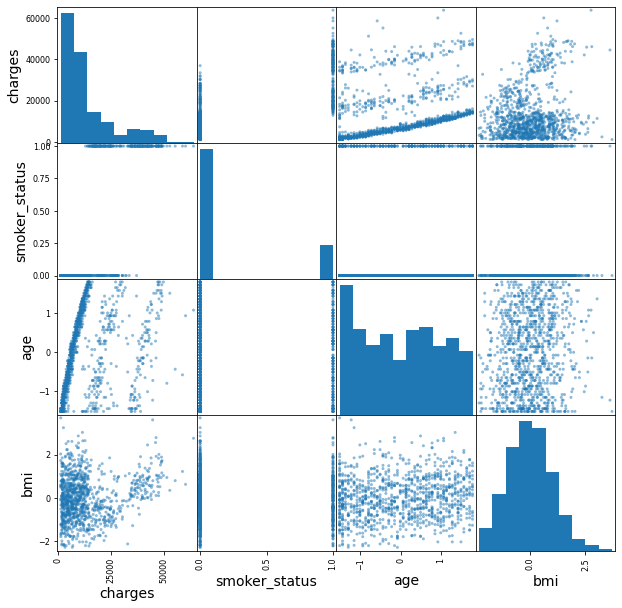

In [131]:
# Get correlation data now that you have all of the data columns in numerical form
y_train = X_train["charges"]
data = pd.DataFrame(np.c_[X_train_prepared.values, y_train.values], columns=["sex","smoker_status","northeast","northwest","southeast","southwest","age","bmi","num_children","charges"])
corr_matrix = data.corr()
print(corr_matrix["charges"].sort_values(ascending = False))

# Print out scatter matrix for most prominent variables 
scatter_matrix(data[["charges","smoker_status","age","bmi"]], figsize=(10,10))

The scatterplot matrix is not very helpful for visualing relationships between continous and discrete (or categorical) variables as you can see in the plot of smoker_status and charges. You can however, make out a bit of a relationship by seeing the density of the number of points on the binary categories: for example, smoke=1 (representing that someone is a smoker) has a higher concentration/density of points higher on the y axis indicating higher charges. That is, if you were to draw a line between the mean of the distribution of points on each axis, it becomes easy to notice that there is an upward trend between smoking and anticipated medical charges. 

# Task 3. Implement Gradient Descent

---



 We are now going to implement the gradient descent linear regression model by hand by implementing our own methods instead of using the built in feature in the LinearRegression Library.

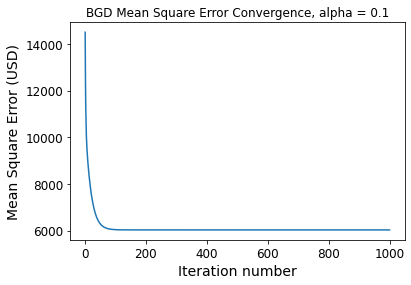

Our implementation: 
 [[ 9192.90786622  3989.841     ]
 [13815.01162604 12430.95335   ]
 [32021.24763916 21659.9301    ]
 [27550.45665523 33475.81715   ]
 [ 9906.01820675  6781.3542    ]
 [ 2331.45102163  2156.7518    ]
 [ 9213.44834874  7537.1639    ]
 [10013.65283316  9447.25035   ]
 [14304.7429352  11090.7178    ]
 [12433.04683797 11840.77505   ]]

Scikit-learn's implementation: 
 [[ 9120.       3989.841  ]
 [13792.      12430.95335]
 [31872.      21659.9301 ]
 [27520.      33475.81715]
 [10112.       6781.3542 ]
 [ 2560.       2156.7518 ]
 [ 9024.       7537.1639 ]
 [ 9920.       9447.25035]
 [14560.      11090.7178 ]
 [12352.      11840.77505]]



In [187]:
# Create a linear regression class to implement gradient descent Linear regression. 

class MyLinearRegression:
  """
  Linear Regressions are modeling methods used to predict outputs given a set 
  number of data points by fitting the model to the data by reducing the error
  between the model and the plotted points.  
  """

  def __init__ (self, alpha=.1, iters=1000):
    """
    Initialize the regressor fields
    """
    self.theta = [];          # parameter vector
    self.alpha = alpha        # learning rate
    self.cost  = []           # cost function
    self.iters = iters        # number of iterations 

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    self.theta: updated value for theta
    self.cost: value of the cost/loss function at each iteration
    """
    # Get number of rows of training data
    n_samples = len(X_train)  
    #print("number of rows: ", n_samples)

    # Add to training data a column of 1s
    X_b = np.c_[np.ones((len(X_train),1)), X_train]
    #print(pd.DataFrame(X_b))

    # # Randomly assign first set of parameters
    self.theta = np.random.randn(10,1)

    y_train = np.array(y_train)
    y_train = y_train.reshape(len(y_train),1)
    
    # Take 1000 steps with size dependent on the gradient of the plot of the 
    # loss function given a certain theta vs the actual value. Update theta 
    # each time thorugh the loop so as to minimize the value of the loss function.
    # Compute the mean square error for each iteration 
    for iteration in range(iters):
      # Compute the gradient based on the current value of theta 
      gradient = (2/n_samples) * X_b.T.dot(X_b.dot(self.theta) - y_train)
      # Update theta in the direction of the gradient    
      self.theta = self.theta - (self.alpha * gradient)                   
      # Get the MSE cost function at a specific iteration and append to cost vector
      val = ((1/n_samples)*sum((X_b.dot(self.theta) - y_train)**2))
      self.cost.append(val**0.5)
      #print("Iter no:",iteration," MSE:",self.cost**0.5)

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent and inputting all of the parameters
    """
    MyLinearRegression.gradientDescent(self, X_train, y_train, self.theta, self.alpha, self.iters)

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    X_b = np.c_[np.ones((len(X_train),1)), X_train]
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y_train) 
    self.theta = theta_best

  def predict(self, X_test):
    """
    Predicting the label
    """
    # Add a ones col to test data for intercept variable representation
    # and take dot product of test data and parameter estimations. 
    X_b = np.c_[np.ones((len(X_test),1)), X_test]
    y_predict = X_b.dot(self.theta)
    return y_predict
    
  def __str__(self):
    """
    Print out the parameter list when calling print() on the class
    """
    return "Parameter Vector: \n {0}".format(self.theta)

  def plotGradientDescent(self):
    """
    Plot the cost function vs the iteration. Must have called fit using gradient descent first
    """
    a = np.c_[np.array(range(1,1001,1)) ,self.cost]
    plt.plot(a[:,0], a[:,1])
    #plt.plot(a[:,0], np.repeat(1, 1000))
    plt.xlabel("Iteration number")
    plt.ylabel("Mean Square Error (USD)")
    plt.title("BGD Mean Square Error Convergence, alpha = {}".format(self.alpha))
    plt.show()
    
# Call an instance of class MyLinearRegression and test methods
myGradientDescentModel = MyLinearRegression(alpha=0.1, iters=1000)
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared.values, y_train.values) 

vals = myGradientDescentModel.predict(X_test_prepared.values)

# Check out the plot of gradient descent!
myGradientDescentModel.plotGradientDescent()

# Print out the first 10 actual values vs the test values to see how we did
print("Our implementation: \n", np.c_[vals[0:10], y_test[0:10].values])
print()

# And compare it to scikit-learn's linear regressor
from sklearn.linear_model import LinearRegression
lin_reg_model = LinearRegression().fit(X_train_prepared.values, y_train.values)
predicts = lin_reg_model.predict(X_test_prepared[0:10])
print("Scikit-learn's implementation: \n", np.c_[predicts, y_test[0:10].values])
print()

# Looks like scikit learn uses almost the same algorithmn we do to perform their default 
# linear regression!!!


OK awesome! Lets get to plotting our implementation of the gradient descent with multiple alphas to see which converges the fastest. 

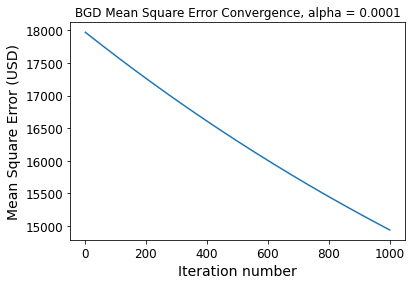

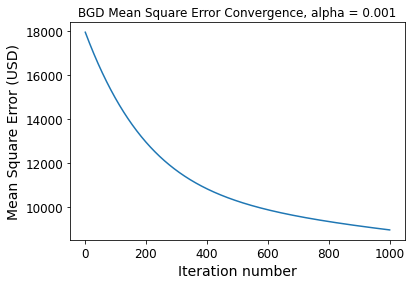

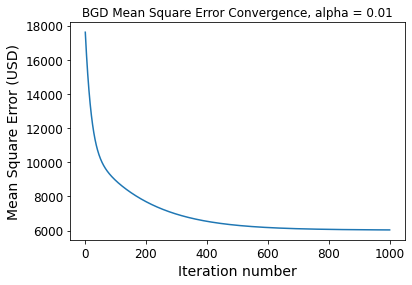

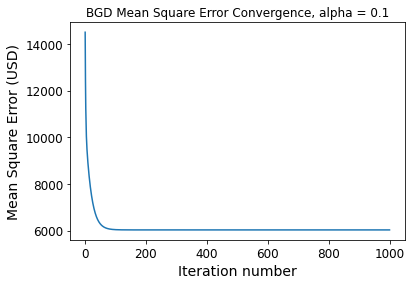

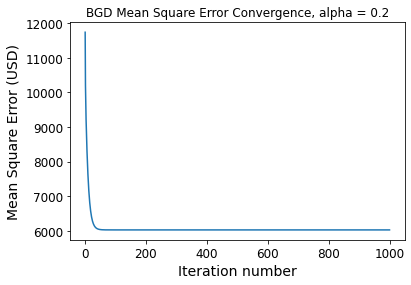

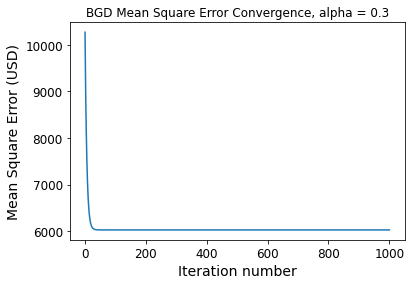

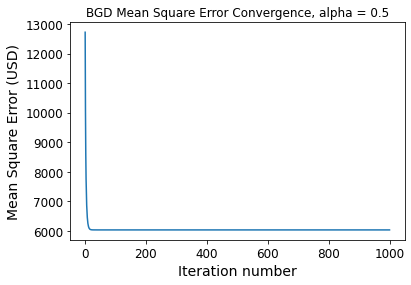

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in add
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in square


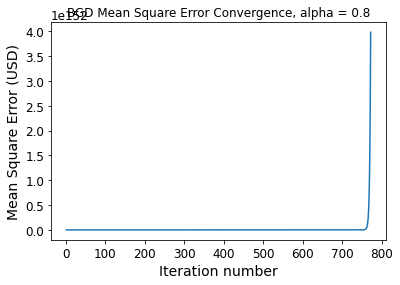

In [188]:
#Iterate through alphas using to fine tune model and plot results 
alphas = [.0001, .001, .01, .1, .2, .3, .5, .8]
for a in alphas:
    myGradientDescentModel = MyLinearRegression(alpha=a, iters=1000)
    myGradientDescentModel.fitUsingGradientDescent(X_train_prepared.values, y_train.values)
    myGradientDescentModel.plotGradientDescent()

Looks like alpha greater than .1 and less than .5 will converge very quickly without any "bouncing" issues but at .8 alpha starts to produce erroneous results from overfitting (indicated by an extremely low MSE and presence of a vertical asymptote at around 760 iterations)

In [189]:
# Get the actual RMSE of our batch gradient descent model 
myGradientDescentModel = MyLinearRegression(alpha=.1, iters=1000)
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared.values, y_train.values)
y_predict = myGradientDescentModel.predict(X_test_prepared)

BGD_error = np.sqrt(mean_squared_error(y_test.values, y_predict))
print("The RMSE error in our BGD model is: ", round(BGD_error,2))

The RMSE error in our BGD model is:  6111.58


# Task 4. Implement normal equation

---



In [190]:
# Implement a normal equation model and print out coefficents
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train_prepared.values, y_train.values)
print("Normal Equation",myNormalEquationModel)
print()

# Compare to normal equation model
myGradientDescentModel = MyLinearRegression(alpha=.1, iters=1000)
myGradientDescentModel.fitUsingGradientDescent(X_train_prepared.values, y_train.values)
print("Gradient Descent",myGradientDescentModel)
print()

Normal Equation Parameter Vector: 
 [ 7627.90200849  -159.44823536 24048.77064721 20610.34544518
 11179.57790048  7454.5393833   4742.70942138  3550.24514755
  2025.94868983   636.76707871]

Gradient Descent Parameter Vector: 
 [[ 6738.73254197]
 [  -98.18226381]
 [23959.0585926 ]
 [ 2291.77963043]
 [ 1959.97960154]
 [ 1046.23350743]
 [ 1444.89297869]
 [ 3550.24514755]
 [ 2025.94868983]
 [  636.76707871]]



In [191]:
# Calculate the performance of the normal equation model using MSE
predictions = myNormalEquationModel.predict(X_test_prepared)
np.c_[y_test.values, predictions]
rmse = np.sqrt(mean_squared_error(y_test.values, predictions))
print("The RMSE error of ouur normal equation model is: ", round(rmse, 2))

The RMSE error of ouur normal equation model is:  13148.93


THIS IS TERRIBLE! The observed data had a max value of ~64,000 and a standard deviation of ~12,000 meaning this estimator has little to no credibility. Notice that the coefficents for the numeric variables (age, bmi, children) are the exact same between the gradient descent and the normal equation model while all the categorical variables are quite different. Why is this? 

#Task 5. Compare Different Implementations 

---

We are going to implement a stochastic gradient descent. This will provide us another model to compare to our implementation of gradient descent. 

In [192]:
# Use the built-in SGD Regressor model 
mySGDModel = SGDRegressor(random_state=42)
mySGDModel.fit(X_train_prepared.values, y_train.values)

y_predict = mySGDModel.predict(X_test_prepared)
mse = mean_squared_error(y_test.values, y_predict)
mySGDModel_rmse = np.sqrt(mse)
print("The RMSE error in our SGD model is: ", round(mySGDModel_rmse,2))

The RMSE error in our SGD model is:  6107.31


# Present Findings 

---

A machine learning stochastic gradient decent model was created to iteratively alter the function parameters of age, number of children, location, bmi, smoking status and sex to create an algorithmn to minimize error in estimating medical expenses with the formentioned variables. 

In analyzing the insurance data set it became apparent that the higher medical costs were strongly (positively) correlated with smokers as well as people who were older or have high BMI. The optimal model created (stochastic gradient descent) was able to estimate the medical expenses of the test population within one half of a standard deviation (~6000 USD) of the mean according to the MSE estimator.    

This model shall be fit for future deployment provided the same categories of information are to be provided with a minimal number of missing values. As this model is based on the iterative technique of gradient descent, it should be able to extrapolate predictions with medical expenses exceeding the current maximum provided as training data, provided a few changes are made in the assumptons hard coded into the model (such as the max medical expense). 

Hyperparameters of learning rate were adjusted to further reduce error and increase the rate at which the model converged to its minimal mean square error.

Future iterations of this model may seek to include additional variables of interest such as exercise/activity level, dieting habits or even income level. Increased accuracy in location may be useful in evaluating the potential risks of insuring a specific subset of individuals but this runs the risk of marginalizing neighborhoods and specific communities. 
